# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from copy import deepcopy
from bs4 import BeautifulSoup, NavigableString
from unicodedata import normalize as uni_normalize
from matplotlib import cm

# Working on HTML versions

## Parsing the HTML file
Let's first read the html file extracted from the REME PDF:

In [2]:
HTML_FILE = "docs/html_pages/rep_metiers-16.html"

In [3]:
with open(HTML_FILE, "r") as reme_html:
    full_html = reme_html.read()

In [4]:
soup = BeautifulSoup(full_html)

## Extracting all < p > elements and preprocessing

We'll begin by deleting all HTML tags that do not contain any human-readable text:

In [5]:
for tag in soup.find_all():
    if len(tag.get_text(strip=True)) == 0:
        tag.extract()

In [6]:
paragraphs = soup.find_all('p')

Now, < p > objects do not always directly contain their text in their ```.string``` attribute.  
Instead, the full text contained within a p element and recursively in its children can be obtained via ```get_text()```.  
We'll thus set the ```string``Now, < p > objects do not always directly contain their text in their .string attribute.
Instead, the full text contained within a p element and recursively in its children can be obtained via get_text().
We'll thus set the string attribute to the value of get_text(), and then remove all children, and this for all < p > tags.` attribute to the value of ```get_text()```, and then remove all children, and this for all
< p > tags.  
  
**Note**: this will also remove any formatting such as with < b > tags.

In [7]:
for par in paragraphs:
    # Retrieves all of the text contained in the <p> tag
    string = par.get_text()
    # Removes all children of the <p> tag
    for child in par.children:
        child.extract()
    # Sets the same text as before as raw text within the <p>
    par.string = string

Moreover, occurences of "1er", "2nd" and "3eme" are counted as separate paragraphs by pdftohtml.
We thus need to remerge them together:

In [8]:
# We'll use a manual iterator instead of a for loop as we want to skip
# elements during the loop
par_iter = iter(paragraphs)
# During the loop, will always be the last <p> tag that has been kept.
prev_par = None
# List that will contain the paragraphs that have been kept
new_list = []

while True:
    try:
        par = next(par_iter)
        text = par.get_text()
        if text in ['er', 'nd', 'eme']:
            # Adds to the previous paragraph the content of this one and the next one too
            # Ex: "Assistance éducative 1" + "er" + "degré"
            next_par = next(par_iter)
            prev_par.string.replace_with(prev_par.get_text() + text + " " + next_par.get_text())
            # Removes the current and next <p> from the page as their content is now in
            # the previous <p>
            par.extract()
            next_par.extract()
        else:
            # Adds the paragraph to the list of kept paragraphs
            new_list.append(par)
            # Updates the previous <p> tag
            prev_par = par
    except StopIteration:
        break
# Update the list of <p> tags to only the ones that have been kept
paragraphs = new_list

## Cleaning the text

We'll replace all non-breaking space characters ```&nbsp``` with usual whitespaces:

In [9]:
for par in paragraphs:
    par.string = par.string.replace(u'\xa0', ' ')

## Extracting the locations

In [10]:
def get_pos(p_object):
    """
    Retrieves the position of a <p> object from its style attribute.
    Returns a pair (top, left) in pixels.
    """
    top, left = re.findall('[0-9]+', p_object.attrs['style'])
    return int(top), int(left)

In [11]:
locations = [get_pos(par) for par in paragraphs]
# Map (top, left) --> <p> object
tops, lefts = [x for x, y in locations], [y for x, y in locations]

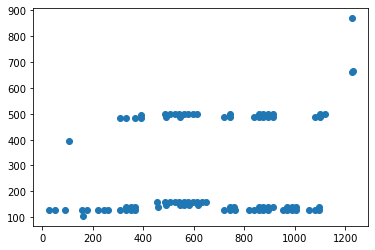

In [12]:
plt.scatter(tops, lefts)

## Clustering into paragraphs

In [13]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance_matrix

/home/clement/.conda/envs/raep/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [14]:
X = np.array([tops, lefts]).T
X.shape

(93, 2)

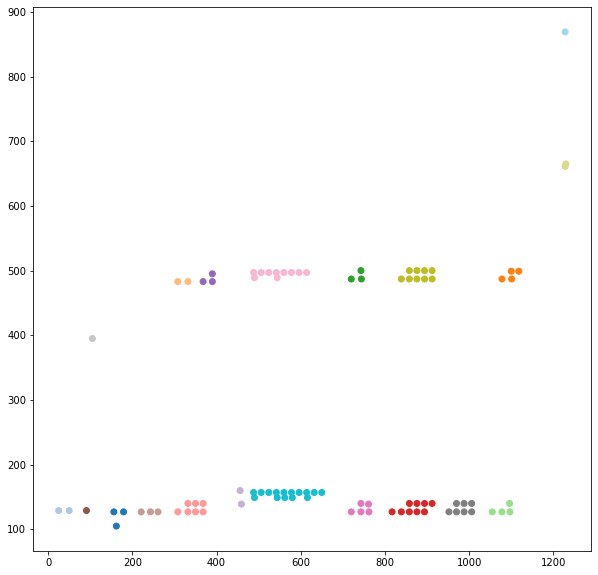

In [15]:
pred = AgglomerativeClustering(linkage="single", distance_threshold=30,
                               n_clusters=None,
                               affinity="l1").fit_predict(X)
plt.figure(figsize=(10, 10))
plt.scatter(tops, lefts, c=pred, cmap="tab20")

In [16]:
n_clusters = pred.max() + 1
clusters = [[] for _ in range(n_clusters)]
for i, prediction in enumerate(pred):
    clusters[prediction].append(paragraphs[i])

## Visualizing clusters
We'll now create a copy the HTML page upon which will be drawn shapes to delimit the clusters in the doc.

In [17]:
cmap = cm.get_cmap('tab20')

In [18]:
for k, cluster in enumerate(clusters):
    # Assign a color to the cluster
    color = cmap(k / n_clusters, bytes=True)
    # Assign that color as background to all elements in that cluster
    for elem in cluster:
        elem['style'] += ";background-color:rgba({}, {}, {}, 0.3);".format(*color)
        # We also add an artificial attribute to indicate the cluster
        elem['cluster'] = k

We'll save the new HTML file so that we can open it with a browser:

In [19]:
NEW_HTML_FILE = "visu_docs/page16.html"
with open(NEW_HTML_FILE, "w") as file:
    file.write(str(soup))